# Pittsburgh “Best Neighborhood” – CSV-only Check-in Notebook

## 2) Parking meters & payment points — pain proxy by group

In [4]:
# --- CONFIG ---
CSV_PATH = "LOCAL_PARKING_CSV_PATH.csv"
GROUP_COL = "auto"  # "auto" | column name | None

OUT_DIR = Path("../outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("../figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 140

def zscore(s):
    s = pd.to_numeric(s, errors='coerce')
    mu, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or pd.isna(sd):
        return pd.Series(0, index=s.index)
    return (s - mu) / sd

def summarize_missing(df):
    miss = df.isna().mean().sort_values(ascending=False)
    return miss[miss > 0]

import re

def parse_rate_to_float(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("$","").strip()
    # keep leading numeric like "1.5", "3", "3/hr"
    s = s.replace("/hr","").replace("/"," ")
    tok = s.split()[0] if s else ""
    try:
        return float(tok)
    except:
        return np.nan

def parse_hours_per_day(x):
    if pd.isna(x): return np.nan
    s = str(x)
    # Very rough heuristic: look for patterns like "8a-6p", "8AM-6PM", "M-Sat, 8a-6p"
    m = re.search(r"(\d{1,2})\s*([ap]m?)?\s*[-–]\s*(\d{1,2})\s*([ap]m?)?", s, re.I)
    if m:
        h1, ampm1, h2, ampm2 = m.groups()
        h1, h2 = int(h1), int(h2)
        def to24(h, ampm):
            if ampm and ampm.lower().startswith("p") and h < 12: return h + 12
            if ampm and ampm.lower().startswith("a") and h == 12: return 0
            return h
        h1_24 = to24(h1, ampm1)
        h2_24 = to24(h2, ampm2)
        span = h2_24 - h1_24
        if span <= 0: span += 24
        return float(span)
    return np.nan


### Load & inspect

In [6]:
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), " Columns:", len(df.columns))
display(df.head(3))
print("\nDtypes:\n", df.dtypes)
print("\nMissingness (top):\n", summarize_missing(df).head(15))


Rows: 1224  Columns: 17


,_id,id,location,location_type,latitude,longitude,status,zone,all_groups,guid,in_service_utc,rate,max_hours,hours,restrictions,special_events,rate_as_of
0,1,410168-SCHEDR4402,SCHENLEY DR,On street,40.440574,-79.948103,Removed,410 - Oakland 4,CMU Study|410 - Oakland 4|Z - Inactive/Removed...,EE7C4FB7-038A-461A-A667-002870BA4155,2012-08-27T11:24:43,NaN,NaN,NaN,NaN,NaN,2019-01-29
1,2,421009-CEDAR-0302,CEDAR AVE,On street,40.451356,-80.001150,Active,421 - NorthSide,NORTHSIDE|421 - NorthSide,5BAC585B-FE5C-4090-ABF8-005D6C670EF1,2013-08-08T11:34:15,$1/hr,4 HRS,"M-Sat, 8a-6p","M-F, 7AM-9AM",NaN,2019-01-29
2,3,409242-NDTHRG0106,N DITHRIDGE ST,On street,40.448784,-79.951793,Active,409 - Oakland 3,409 - Oakland 3|OAKLAND3,F4BDCD95-6853-413F-A1C6-009AF3F9D725,2012-09-04T16:08:27,$3/hr,No Max,"M-Sat, 8a-6p",NaN,NaN,2019-01-29



Dtypes:
 _id                 int64
id                 object
location           object
location_type      object
latitude          float64
longitude         float64
status             object
zone               object
all_groups         object
guid               object
in_service_utc     object
rate               object
max_hours          object
hours              object
restrictions       object
special_events     object
rate_as_of         object
dtype: object

Missingness (top):
 special_events    0.951797
restrictions      0.929739
hours             0.165850
rate              0.165850
max_hours         0.165850
longitude         0.072712
latitude          0.072712
in_service_utc    0.000817
location_type     0.000817
dtype: float64


### Detect grouping column

In [7]:
if GROUP_COL == "auto":
    prefs = ["neighborhood","zone","district","parking_zone","Neighborhood","Zone","District"]
    GROUP_COL = next((c for c in prefs if c in df.columns), None)
print("Using GROUP_COL:", GROUP_COL)


Using GROUP_COL: zone


### Build a simple pain proxy per point, then aggregate by group

,group,points,rate_median,hours_median,daily_cost_median,pain_proxy
34,402 - Downtown 2,66,4.0,10.0,40.0,4.840321
33,401 - Downtown 1,54,4.0,10.0,40.0,4.419636
41,409 - Oakland 3,88,3.0,10.0,30.0,4.324327
40,408 - Oakland 2,48,3.0,10.0,30.0,2.922046
47,415 - SS & SSW,103,1.5,10.0,15.0,2.919309
54,422 - Northshore,40,3.0,10.0,30.0,2.641590
42,410 - Oakland 4,56,2.5,10.0,25.0,2.558878
39,407 - Oakland 1,35,3.0,10.0,30.0,2.466305
35,403 - Uptown,86,1.5,10.0,15.0,2.323340
53,421 - NorthSide,98,1.0,10.0,10.0,2.100400


Saved: ..\outputs\parking_pain_by_group.csv


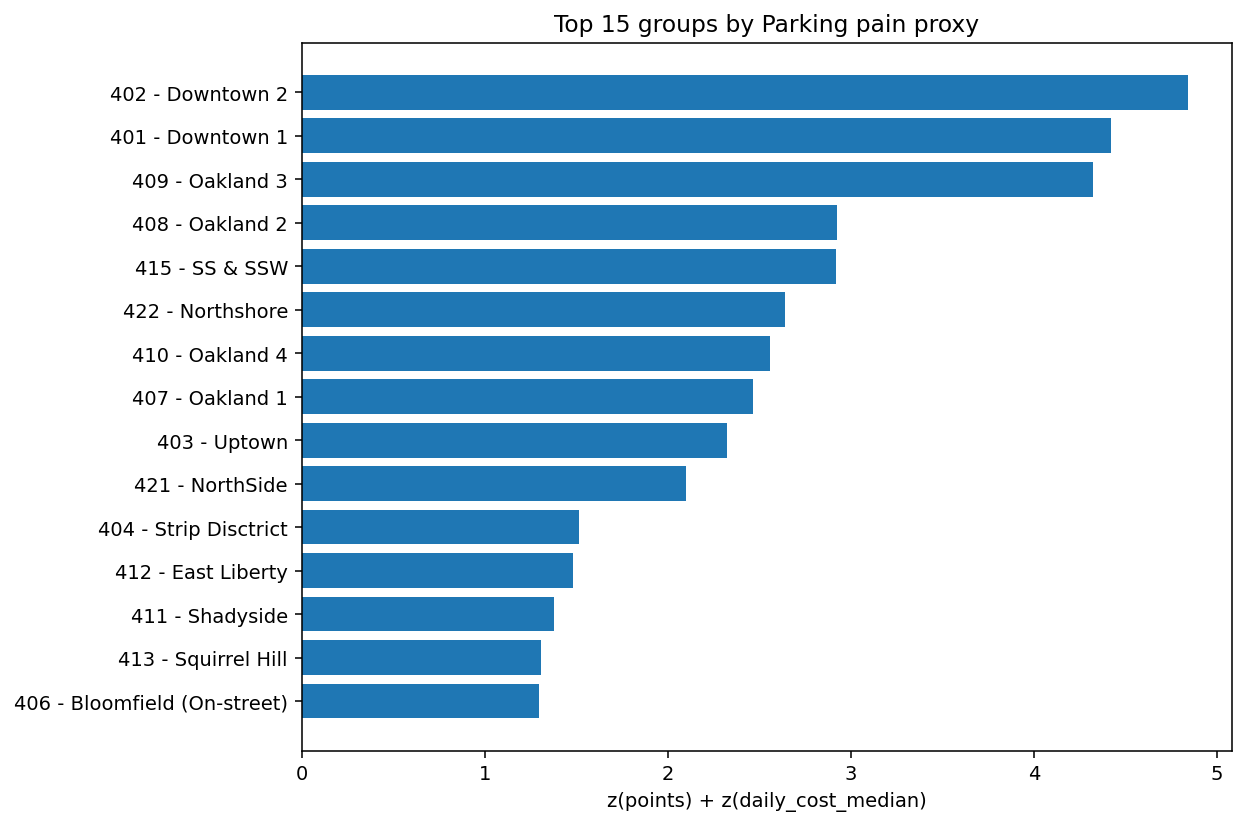

Saved figure: ..\figures\top15_parking_pain.png


In [8]:
if "rate" in df.columns:
    df["rate_per_hour"] = df["rate"].apply(parse_rate_to_float)
else:
    df["rate_per_hour"] = np.nan
if "hours" in df.columns:
    df["hours_per_day"] = df["hours"].apply(parse_hours_per_day)
else:
    df["hours_per_day"] = np.nan
df["daily_cost_proxy"] = df["rate_per_hour"] * df["hours_per_day"]

if GROUP_COL is not None and GROUP_COL in df.columns:
    agg = (df.groupby(GROUP_COL)
           .agg(points=("rate_per_hour","size"),
                rate_median=("rate_per_hour","median"),
                hours_median=("hours_per_day","median"),
                daily_cost_median=("daily_cost_proxy","median"))
           .reset_index()
           .rename(columns={GROUP_COL:"group"}))
    # Pain score: density proxy unavailable here, so rely on cost + points
    agg["pain_proxy"] = zscore(agg["points"].fillna(0)) + zscore(agg["daily_cost_median"].fillna(0))
    agg = agg.sort_values("pain_proxy", ascending=False)
    display(agg.head(10))

    out_csv = OUT_DIR / "parking_pain_by_group.csv"
    agg.to_csv(out_csv, index=False)
    print("Saved:", out_csv)

    # Plot
    top = agg.head(15)
    plt.figure(figsize=(9,6))
    plt.barh(top["group"], top["pain_proxy"])
    plt.gca().invert_yaxis()
    plt.title("Top 15 groups by Parking pain proxy")
    plt.xlabel("z(points) + z(daily_cost_median)")
    plt.tight_layout()
    fig_path = FIG_DIR / "top15_parking_pain.png"
    plt.savefig(fig_path, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved figure:", fig_path)
else:
    print("No grouping column found. You can still inspect distributions:")
    print(df[["rate_per_hour","hours_per_day","daily_cost_proxy"]].describe())
